In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random

from models.lstm import LSTMRegressor
from models.mlp_encoder import MLPEncoder
from utils.stock_data import get_data_loaders, StockIndex

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
window_size=7
BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 448,
        "num_layers": 1,
        "dropout": 0.4239957160428596,
        "batch_size": 64,
        "lr": 0.0001838881981064509
    },
    StockIndex.AAPL: {
        "hidden_dim": 384,
        "num_layers": 1,
        "dropout": 0.4977111921526725,
        "batch_size": 64,
        "lr": 0.00020753729233794063
    },
    StockIndex.KO: {
        "hidden_dim": 448,
        "num_layers": 1,
        "dropout": 0.4763314866611378,
        "batch_size": 16,
        "lr": 0.00048306012121073996
    }
}

BEST_MLP_PARAMS = {
    StockIndex.NVDA: {
        "layer_0_dim": 96,
        "dropout": 0.11101877285806869,
        "lr": 0.0001371417249659207
    },
    StockIndex.AAPL: {
        "layer_0_dim": 224,
        "dropout": 0.4038629449927321,
        "lr": 0.00018567292554405796
    },
    StockIndex.KO: {
        "layer_0_dim": 256,
        "dropout": 0.2966879994967002,
        "lr": 0.00048306012121073996
    }
}

## Training MLP-Fixed LSTM for each stock ##

### NVIDIA ###

In [7]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
mlp_params = BEST_MLP_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.022329648360610008
Epoch 2: Train=0.0023830166878178716
Epoch 3: Train=0.0010034366557374597
Epoch 4: Train=0.0006583257927559316
Epoch 5: Train=0.0005859392893034965
Epoch 6: Train=0.0005628347035963088
Epoch 7: Train=0.0004872687323950231
Epoch 8: Train=0.0004459446860710159
Epoch 9: Train=0.0004577391094062477
Epoch 10: Train=0.00042662010295316575
Epoch 11: Train=0.00039125262876041236
Epoch 12: Train=0.0003767290635732934
Epoch 13: Train=0.00036215795029420405
Epoch 14: Train=0.0003887151111848652
Epoch 15: Train=0.0003923123568529263
Epoch 16: Train=0.00036044473526999357
Epoch 17: Train=0.0003452966688200831
Epoch 18: Train=0.0003615156415617093
Epoch 19: Train=0.00034031167975626884
Epoch 20: Train=0.00036316251498647034
Epoch 21: Train=0.000351265583303757
Epoch 22: Train=0.00034784252056851983
Epoch 23: Train=0.00032163784257136283
Epoch 24: Train=0.0003218623087741435
Epoch 25: Train=0.00033255847811233254
Epoch 26: Train=0.00031306971330195664
Epoch 27: Tra

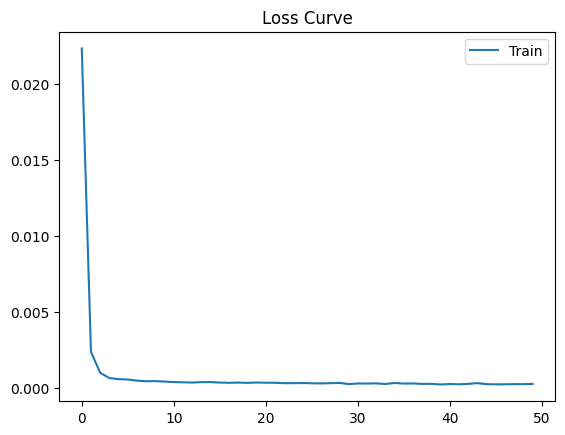

In [16]:
nvda_lstm = LSTMRegressor(
    input_dim=mlp_params['layer_0_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

nvda_encoder = MLPEncoder(input_dim=input_dim,
                         layer_dims=[mlp_params['layer_0_dim']],
                         dropout=mlp_params['dropout']
                        ).to(device)


optimizer = optim.Adam([
        {'params': nvda_encoder.parameters(), 'lr': mlp_params['lr']},
        {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 14.2057
Test MAE : 12.9406


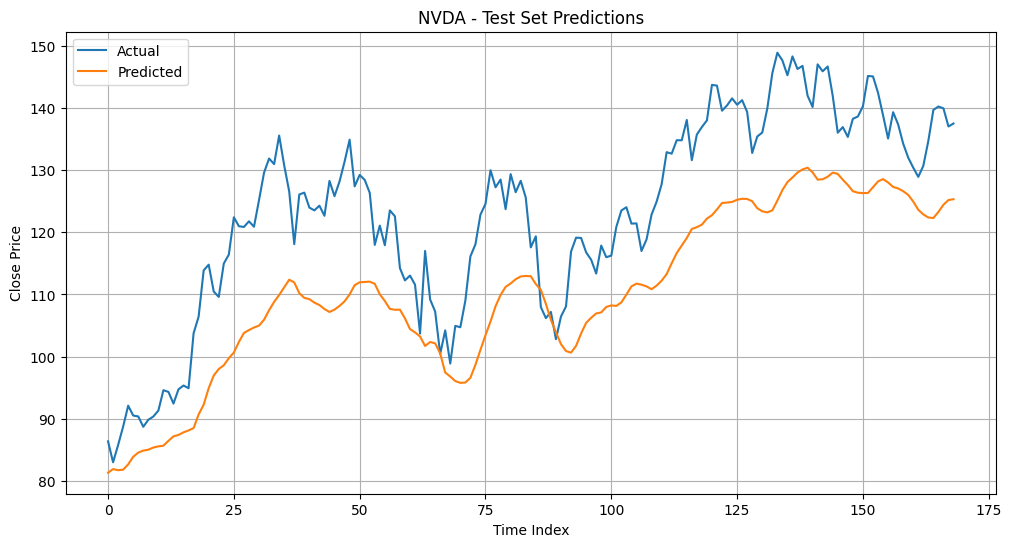

Actual Volatility (std of returns): 0.0328
Predicted Volatility             : 0.0098


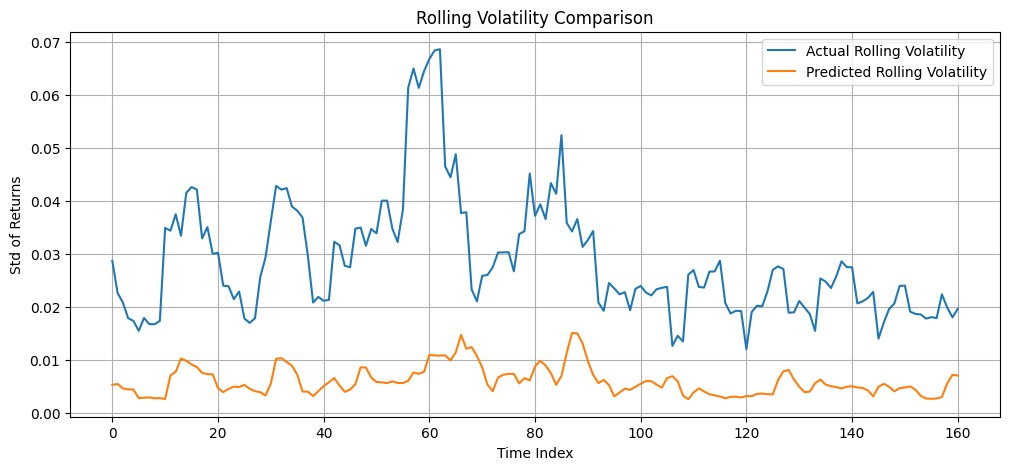

In [17]:
# Ensure both models are in eval mode
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)             # [B, T, D]
        pred = nvda_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
nvda_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
nvda_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(nvda_targets_unscaled, nvda_preds_unscaled))
mae = mean_absolute_error(nvda_targets_unscaled, nvda_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(nvda_targets_unscaled, label="Actual")
plt.plot(nvda_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(nvda_targets_unscaled) / nvda_targets_unscaled[:-1]
pred_returns   = np.diff(nvda_preds_unscaled) / nvda_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

## Apple ##

In [18]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
mlp_params = BEST_MLP_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.014879084208091213
Epoch 2: Train=0.0016165257483306858
Epoch 3: Train=0.0014101432358864883
Epoch 4: Train=0.0014141538716038935
Epoch 5: Train=0.0014123964685513967
Epoch 6: Train=0.0012045852261397874
Epoch 7: Train=0.0014341003969993743
Epoch 8: Train=0.001193102828410426
Epoch 9: Train=0.0012694734805428207
Epoch 10: Train=0.0011391749524986465
Epoch 11: Train=0.001051225271158278
Epoch 12: Train=0.0013636743809764434
Epoch 13: Train=0.0011269704383184117
Epoch 14: Train=0.0011342622520815995
Epoch 15: Train=0.0010713891542488427
Epoch 16: Train=0.001138076379617695
Epoch 17: Train=0.0010520755818979157
Epoch 18: Train=0.0010509247514724994
Epoch 19: Train=0.0010784415641653755
Epoch 20: Train=0.001110685567696099
Epoch 21: Train=0.0010243339191844706
Epoch 22: Train=0.0010362076852353044
Epoch 23: Train=0.0009530872459913782
Epoch 24: Train=0.0010443097003970784
Epoch 25: Train=0.0009040555853815279
Epoch 26: Train=0.000901142467751704
Epoch 27: Train=0.000950158

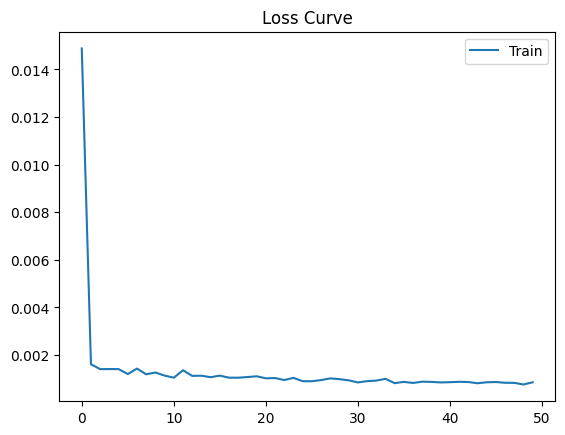

In [25]:
aapl_lstm = LSTMRegressor(
    input_dim=mlp_params['layer_0_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

aapl_encoder = MLPEncoder(input_dim=input_dim,
                         layer_dims=[mlp_params['layer_0_dim']],
                         dropout=mlp_params['dropout']
                        ).to(device)


optimizer = optim.Adam([
        {'params': aapl_encoder.parameters(), 'lr': mlp_params['lr']},
        {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 13.9227
Test MAE : 12.2669


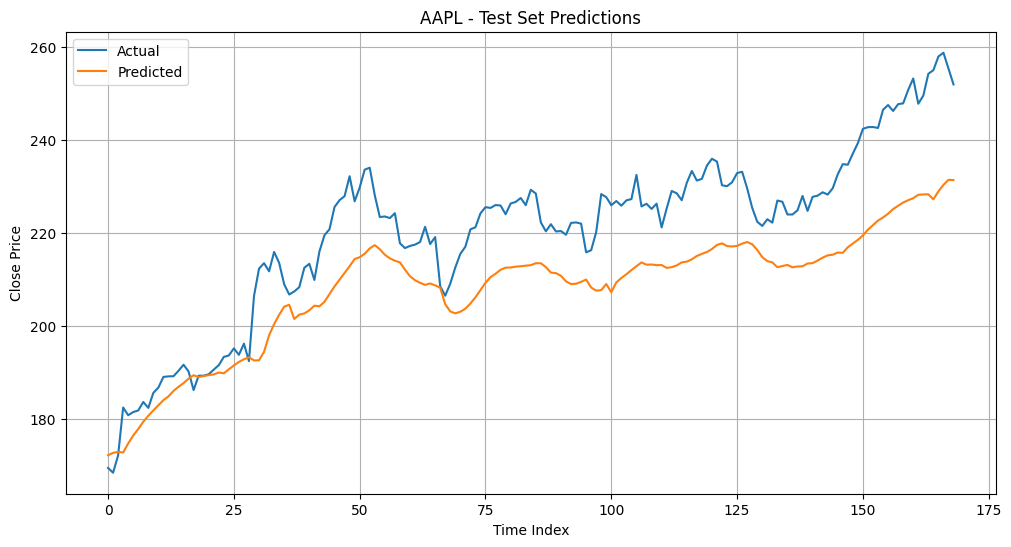

Actual Volatility (std of returns): 0.0145
Predicted Volatility             : 0.0046


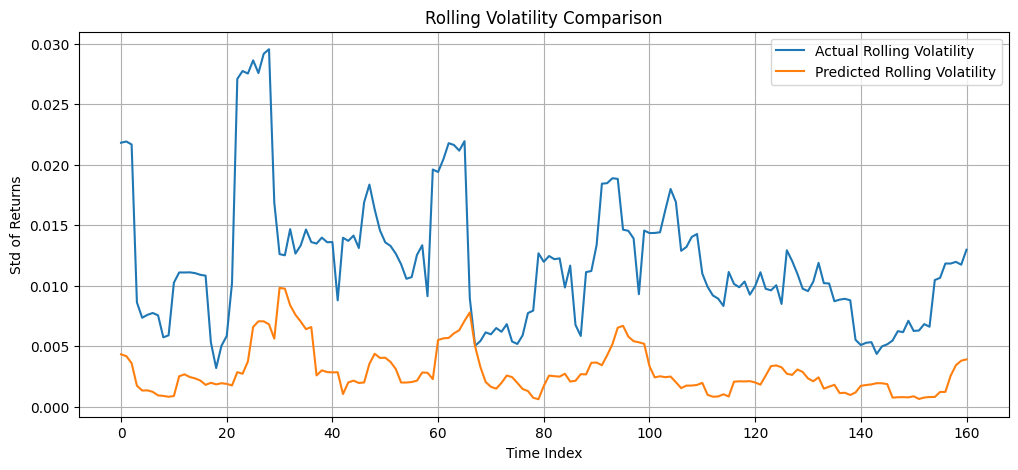

In [20]:
# Ensure both models are in eval mode
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)             # [B, T, D]
        pred = aapl_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
aapl_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
aapl_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(aapl_targets_unscaled, aapl_preds_unscaled))
mae = mean_absolute_error(aapl_targets_unscaled, aapl_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(aapl_targets_unscaled, label="Actual")
plt.plot(aapl_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(aapl_targets_unscaled) / aapl_targets_unscaled[:-1]
pred_returns   = np.diff(aapl_preds_unscaled) / aapl_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()

## Coke ##

In [21]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
mlp_params = BEST_MLP_PARAMS[stock]
train_dl, test_dl, scalers = get_data_loaders(stock, window_size, batch_size = lstm_params["batch_size"],
                                                      use_val_split=False)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train=0.013577785360570433
Epoch 2: Train=0.00163641855628653
Epoch 3: Train=0.0014108411251623747
Epoch 4: Train=0.0012444679859338911
Epoch 5: Train=0.0013724008338135488
Epoch 6: Train=0.0014723477355378558
Epoch 7: Train=0.0011491992056953035
Epoch 8: Train=0.001121896081557027
Epoch 9: Train=0.001228848307021903
Epoch 10: Train=0.0011476068478195242
Epoch 11: Train=0.0010287337807110613
Epoch 12: Train=0.001053049471911344
Epoch 13: Train=0.001054672946779509
Epoch 14: Train=0.0010724735659114414
Epoch 15: Train=0.001114026876754419
Epoch 16: Train=0.0009613475571809845
Epoch 17: Train=0.0011169227067089518
Epoch 18: Train=0.0009917424414941872
Epoch 19: Train=0.0012242671906609428
Epoch 20: Train=0.0009912197887333054
Epoch 21: Train=0.0008826310548818473
Epoch 22: Train=0.001042286930970302
Epoch 23: Train=0.0008868629352725817
Epoch 24: Train=0.0009476078575420561
Epoch 25: Train=0.0010510131331910896
Epoch 26: Train=0.0010516969883941454
Epoch 27: Train=0.000939036788

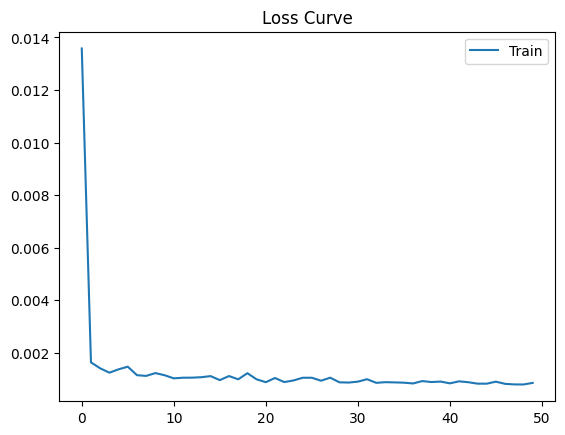

In [23]:
ko_lstm = LSTMRegressor(
    input_dim=mlp_params['layer_0_dim'],
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

ko_encoder = MLPEncoder(input_dim=input_dim,
                         layer_dims=[mlp_params['layer_0_dim']],
                         dropout=mlp_params['dropout']
                        ).to(device)


optimizer = optim.Adam([
        {'params': ko_encoder.parameters(), 'lr': mlp_params['lr']},
        {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
    ])
criterion = nn.MSELoss()
train_losses = []

for epoch in range(50):
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}: Train={train_loss}")#: Val={val_loss}")

plt.plot(train_losses, label='Train')
# plt.plot(val_losses, label='Val')
plt.legend()
plt.title("Loss Curve")
plt.show()

Test RMSE: 5.2145
Test MAE : 4.5561


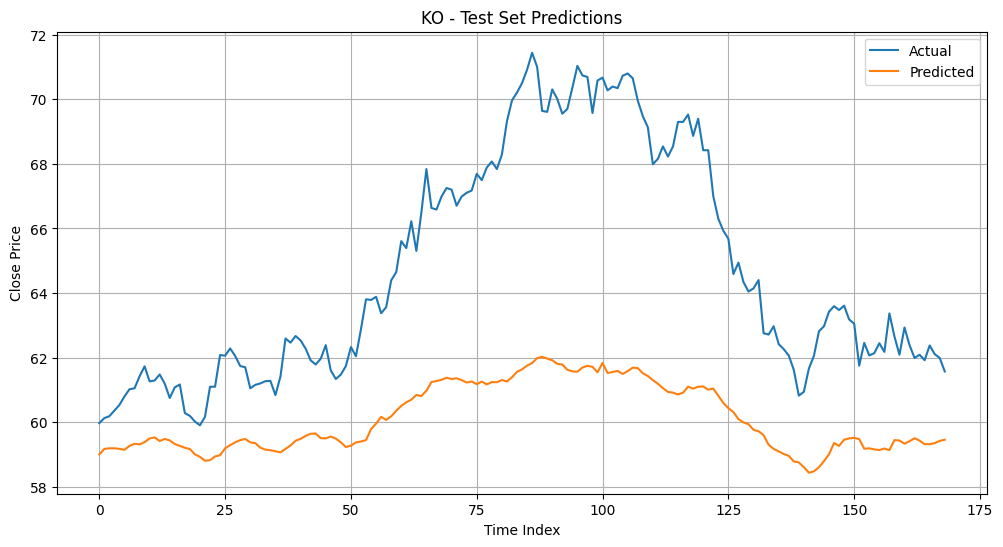

Actual Volatility (std of returns): 0.0083
Predicted Volatility             : 0.0020


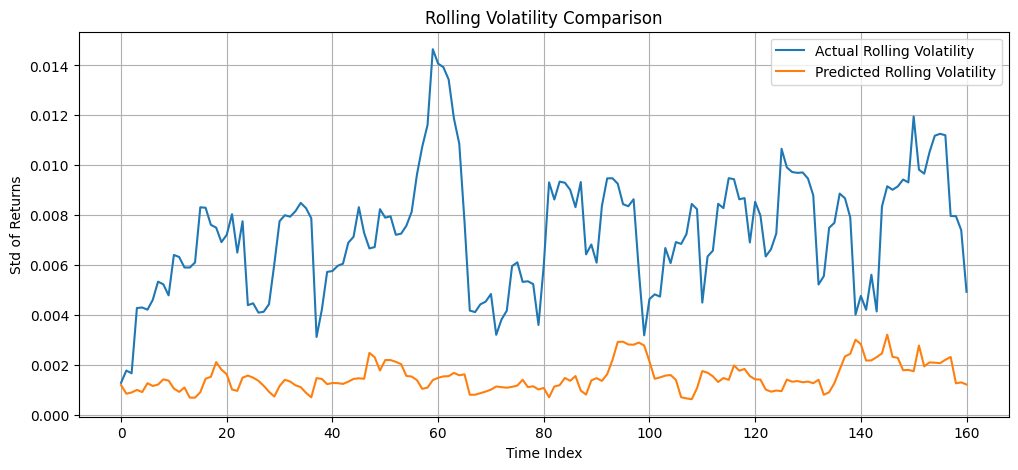

In [24]:
# Ensure both models are in eval mode
ko_encoder.eval()
ko_lstm.eval()

preds, targets = [], []

with torch.no_grad():
    for xb, yb in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)             # [B, T, D]
        pred = ko_lstm(encoded).squeeze().cpu().numpy()
        preds.extend(pred)
        targets.extend(yb.numpy())

# Unscale predictions if needed
close_scaler = scalers[f"{stock.value}_Close"]
ko_preds_unscaled = close_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
ko_targets_unscaled = close_scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

# Compute error metrics
rmse = np.sqrt(mean_squared_error(ko_targets_unscaled, ko_preds_unscaled))
mae = mean_absolute_error(ko_targets_unscaled, ko_preds_unscaled)

# Print metrics
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot predictions vs actuals
plt.figure(figsize=(12, 6))
plt.plot(ko_targets_unscaled, label="Actual")
plt.plot(ko_preds_unscaled, label="Predicted")
plt.legend()
plt.title(f"{stock.value} - Test Set Predictions")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.grid(True)
plt.show()

actual_returns = np.diff(ko_targets_unscaled) / ko_targets_unscaled[:-1]
pred_returns   = np.diff(ko_preds_unscaled) / ko_preds_unscaled[:-1]
actual_vol = np.std(actual_returns)
pred_vol   = np.std(pred_returns)

print(f"Actual Volatility (std of returns): {actual_vol:.4f}")
print(f"Predicted Volatility             : {pred_vol:.4f}")

window = 7  # rolling window in days

actual_vol_rolling = np.std([
    actual_returns[i:i+window] for i in range(len(actual_returns) - window)
], axis=1)

pred_vol_rolling = np.std([
    pred_returns[i:i+window] for i in range(len(pred_returns) - window)
], axis=1)

plt.figure(figsize=(12, 5))
plt.plot(actual_vol_rolling, label='Actual Rolling Volatility')
plt.plot(pred_vol_rolling, label='Predicted Rolling Volatility')
plt.title("Rolling Volatility Comparison")
plt.xlabel("Time Index")
plt.ylabel("Std of Returns")
plt.legend()
plt.grid(True)
plt.show()